# **Analiza delovno aktivnega prebivalstva in BDP Slovenije**

### Podatki

*[Delovno aktivno prebivalstvo](https://podatki.gov.si/dataset/surs0700992s)*

*[Izdatkovna struktura BDP](https://podatki.gov.si/dataset/surs0301935s?resource_id=8935a064-5888-4ab9-9066-0838f6f2743b)*

In [2]:
#Imports
from pyaxis import pyaxis
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import csv

In [3]:
# Branje CSV datotek
data_delo = pd.read_csv('../podatki/delo.csv', sep=';', encoding='utf-8')
data_bdp = pd.read_csv('../podatki/bdp.csv', sep=';', encoding='utf-8')
data_preb = pd.read_csv('../podatki/prebivalstvo.csv', sep=';', encoding='utf-8')

print(data_delo.columns.tolist())
print(data_bdp.columns.tolist())
print(data_preb.columns.tolist())


['STATISTIČNA REGIJA', 'STAROSTNI RAZRED', 'MESEC', 'DATA']
['TRANSAKCIJE', 'MERITVE', 'LETO', 'DATA']
['MERITVE', 'STATISTIČNA REGIJA', 'LETO', 'DATA']


In [4]:
# Obdelava podatkov o delovno aktivnih
data_delo['YEAR'] = data_delo['MESEC'].str[:4].astype(int)
data_delo['DATA'] = pd.to_numeric(data_delo['DATA'], errors='coerce')
data_delo = data_delo[data_delo['YEAR'] != data_delo['YEAR'].max()]
data_slovenia = data_delo[data_delo['STATISTIČNA REGIJA'] == 'SLOVENIJA']

# Obdelava podatkov o BDP
data_bdp['DATA'] = pd.to_numeric(data_bdp['DATA'], errors='coerce')
data_bdp = data_bdp[data_bdp['LETO'] != data_bdp['LETO'].max()]

# Obdelava podatkov o prebivalstvu
data_preb['DATA'] = pd.to_numeric(data_preb['DATA'], errors='coerce')
data_preb = data_preb[data_preb['LETO'] != data_preb['LETO'].max()]

Za lažjo primerjavo podatkov smo izbločili zadnje (trenutno) leto iz podatkov.

## Delovno prebivalstvo v Sloveniji

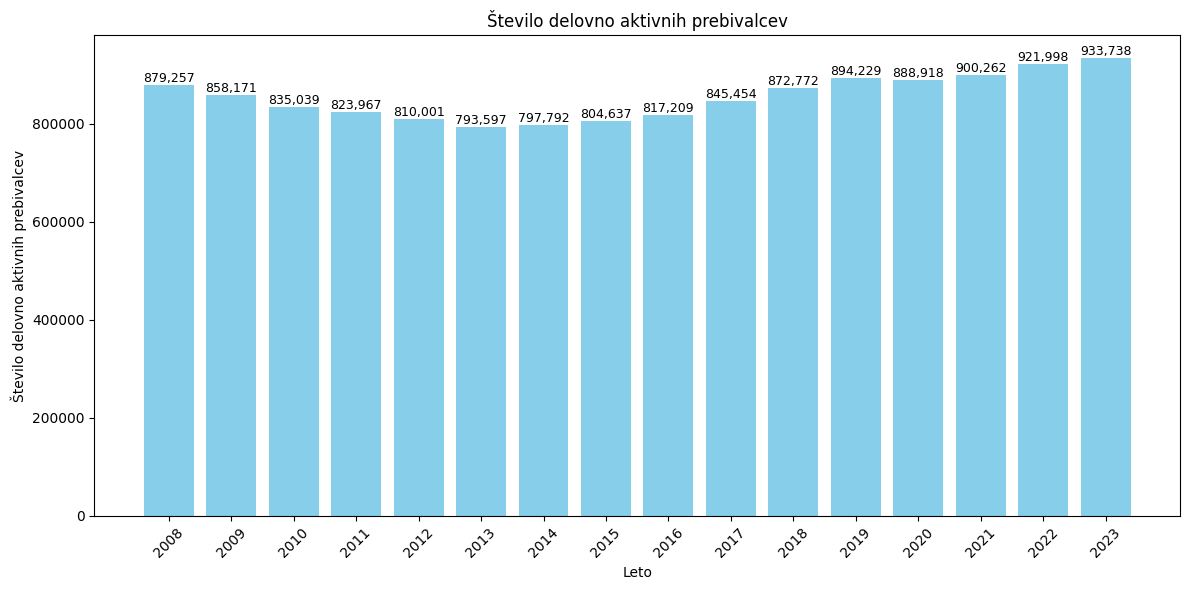

In [5]:
filtrirani = data_preb[
    (data_preb['MERITVE'] == 'Število delovno aktivnih prebivalcev (po prebivališču)') &
    (data_preb['STATISTIČNA REGIJA'] == 'SLOVENIJA')
]

filtrirani = filtrirani.sort_values('LETO')

plt.figure(figsize=(12,6))
bars = plt.bar(filtrirani['LETO'], filtrirani['DATA'], color='skyblue')
plt.title('Število delovno aktivnih prebivalcev')
plt.xlabel('Leto')
plt.ylabel('Število delovno aktivnih prebivalcev')
plt.xticks(filtrirani['LETO'], rotation=45)

# Dodajanje oznak nad stolpci
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Graf prikazije, da se število aktivnega delavnega prebivalstva veča.

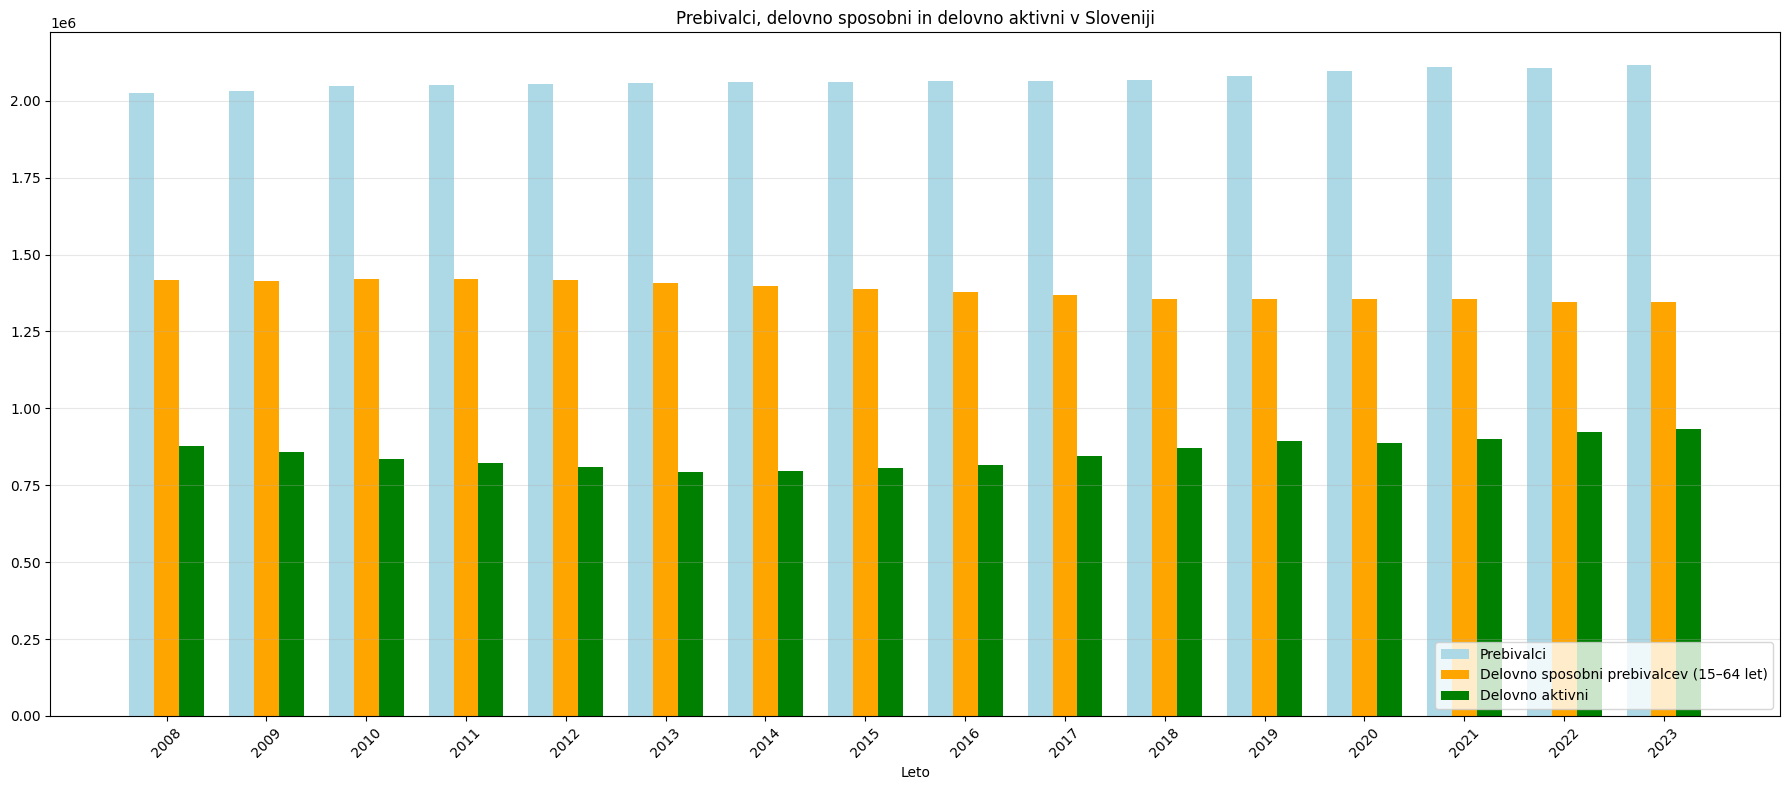

,LETO,Prebivalci,Delovno sposobni,Delovno aktivni,Delež prebivalcev 15–64 let (%),Delež aktivnih med sposobnimi (%)
0,2008,2025866.0,1418106.20,879257.0,70.0,62.00
1,2009,2032362.0,1414523.95,858171.0,69.6,60.67
2,2010,2046976.0,1420601.34,835039.0,69.4,58.78
3,2011,2050189.0,1420780.98,823967.0,69.3,57.99
4,2012,2055496.0,1416236.74,810001.0,68.9,57.19
5,2013,2058821.0,1408233.56,793597.0,68.4,56.35
6,2014,2061085.0,1399476.72,797792.0,67.9,57.01
7,2015,2062874.0,1388314.20,804637.0,67.3,57.96
8,2016,2064188.0,1376813.40,817209.0,66.7,59.36
9,2017,2065895.0,1367622.49,845454.0,66.2,61.82


In [6]:
# Filtriraj podatke za Slovenijo
preb = data_preb[
    (data_preb['MERITVE'] == 'Število prebivalcev - 1. januar') &
    (data_preb['STATISTIČNA REGIJA'] == 'SLOVENIJA')
][['LETO', 'DATA']].rename(columns={'DATA': 'Prebivalci'})

aktivni = data_preb[
    (data_preb['MERITVE'] == 'Število delovno aktivnih prebivalcev (po prebivališču)') &
    (data_preb['STATISTIČNA REGIJA'] == 'SLOVENIJA')
][['LETO', 'DATA']].rename(columns={'DATA': 'Delovno aktivni'})

delez = data_preb[
    (data_preb['MERITVE'] == 'Delež prebivalcev, starih 15 do 64 let (%) - 1. januar') &
    (data_preb['STATISTIČNA REGIJA'] == 'SLOVENIJA')
][['LETO', 'DATA']].rename(columns={'DATA': 'Delež prebivalcev 15–64 let (%)'})

# Združi in izračunaj delovno sposobne
merged = preb.merge(aktivni, on='LETO').merge(delez, on='LETO')
merged = merged.sort_values('LETO')
merged['Delovno sposobni'] = merged['Prebivalci'] * merged['Delež prebivalcev 15–64 let (%)'] / 100

# Priprava za graf
leto = merged['LETO'].astype(str)
x = np.arange(len(leto))
bar_width = 0.25

# Risanje
fig, ax = plt.subplots(figsize=(18, 8))

ax.bar(x - bar_width, merged['Prebivalci'], width=bar_width, label='Prebivalci', color='lightblue')
ax.bar(x, merged['Delovno sposobni'], width=bar_width, label='Delovno sposobni prebivalcev (15–64 let)', color='orange')
ax.bar(x + bar_width, merged['Delovno aktivni'], width=bar_width, label='Delovno aktivni', color='green')

ax.set_xlabel('Leto')
ax.set_title('Prebivalci, delovno sposobni in delovno aktivni v Sloveniji')
ax.set_xticks(x)
ax.set_xticklabels(leto, rotation=45)
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Prikaži tabelo vseh podatkov
# Izračun deleža delovno aktivnih izmed delovno sposobnih
merged['Delež aktivnih med sposobnimi (%)'] = (
    merged['Delovno aktivni'] / merged['Delovno sposobni'] * 100
).round(2)

# Prikaz preglednice z novim stolpcem
merged[['LETO', 'Prebivalci', 'Delovno sposobni', 'Delovno aktivni', 'Delež prebivalcev 15–64 let (%)', 'Delež aktivnih med sposobnimi (%)']].round(2)

Opazimo, da se število prebivalcev ter število in delež delovno aktivnega prebivalstva povečujeta, medtem ko se delež delovno sposobnih prebivalcev zmanjšuje, kar je posledica staranja prebivalstva.

## Delovno prebivalstvo glede na starost

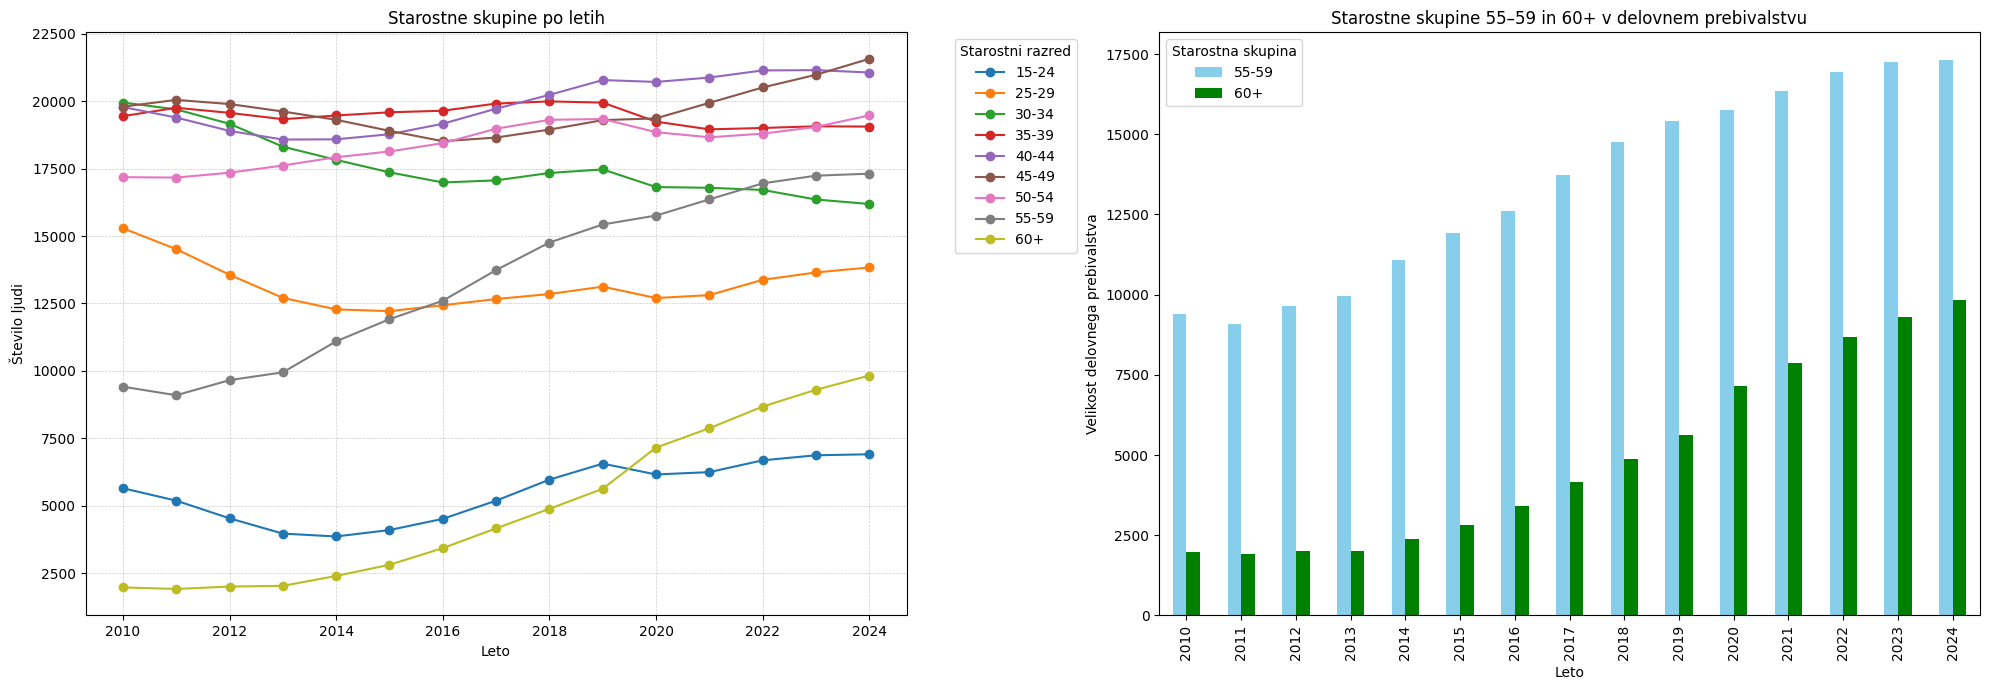

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

# Črtni graf – vse starostne skupine
grouped = data_delo.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].mean().unstack()
grouped.index = grouped.index.astype(int)
grouped = grouped.sort_index()

for age_group in grouped.columns:
    axs[0].plot(grouped.index, grouped[age_group], marker='o', label=age_group)

axs[0].set_xlabel('Leto')
axs[0].set_ylabel('Število ljudi')
axs[0].set_title('Starostne skupine po letih')
axs[0].legend(title='Starostni razred', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)

# Stolpčni graf – samo skupini 55–59 in 60+
age_groups = data_delo[data_delo['STAROSTNI RAZRED'].isin(['55-59', '60+'])]
age_group_yearly_data = age_groups.groupby(['YEAR', 'STAROSTNI RAZRED'])['DATA'].mean().unstack()

age_group_yearly_data.plot(kind='bar', stacked=False, ax=axs[1], color=['skyblue', 'green'])
axs[1].set_xlabel('Leto')
axs[1].set_ylabel('Velikost delovnega prebivalstva')
axs[1].set_title('Starostne skupine 55–59 in 60+ v delovnem prebivalstvu')
axs[1].legend(title='Starostna skupina')

plt.tight_layout()
plt.show()

Iz levega grafa je razvidno, da je vse več ljudi, starejših od 50 let, delovno aktivnih. Eden od glavnih razlogov za to, je staranje prebivalstva in daljšanje življenske dobe.

Iz desnim grafom še bolj podrobno vidimo, da se ljudje vse kasneje upokojujejo, ker kasneje dosegajo pogoje za upokojitev. To je tudi posledica slabih pokojnin, ki si jih višajo s podaljševanjem delovne dobe.

## Struktura delovnega prebivalstva po regijah

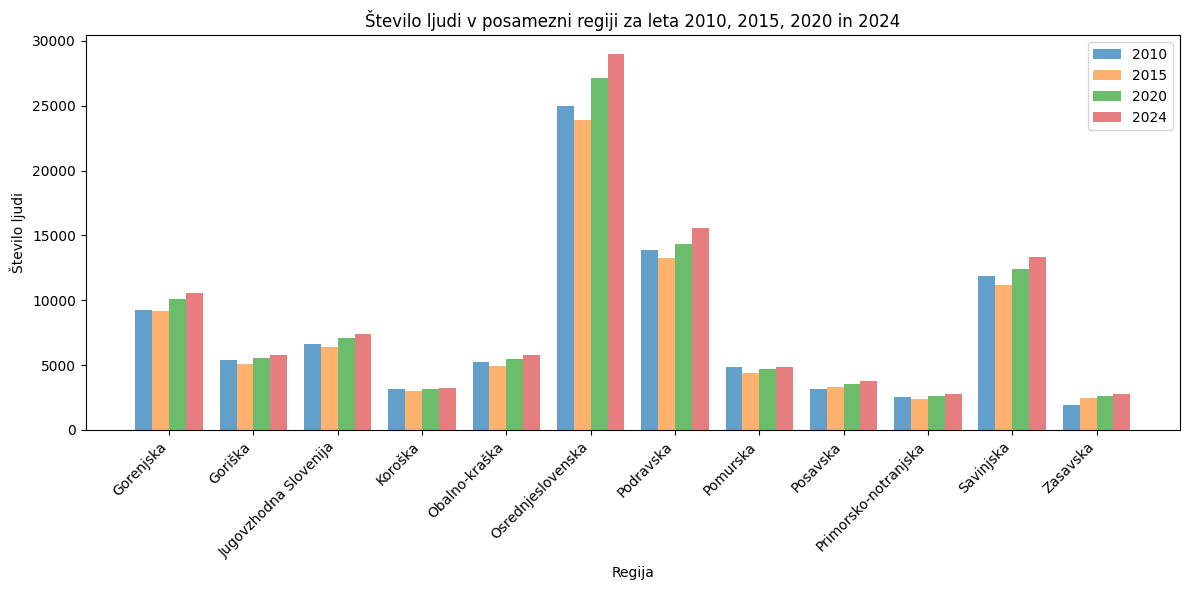

In [8]:
data_2010_regions = data_delo[data_delo['YEAR'] == 2010]
data_2015_regions = data_delo[data_delo['YEAR'] == 2015]
data_2020_regions = data_delo[data_delo['YEAR'] == 2020]
data_2024_regions = data_delo[data_delo['YEAR'] == 2024]

region_data_2010 = data_2010_regions[data_2010_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].mean()
region_data_2015 = data_2015_regions[data_2015_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].mean()
region_data_2020 = data_2020_regions[data_2020_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].mean()
region_data_2024 = data_2024_regions[data_2024_regions['STATISTIČNA REGIJA'] != 'SLOVENIJA'].groupby('STATISTIČNA REGIJA')['DATA'].mean()

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(region_data_2010.index))

plt.bar(x - 1.5 * bar_width, region_data_2010.values, width=bar_width, alpha=0.7, label='2010')
plt.bar(x - 0.5 * bar_width, region_data_2015.values, width=bar_width, alpha=0.6, label='2015')
plt.bar(x + 0.5 * bar_width, region_data_2020.values, width=bar_width, alpha=0.7, label='2020')
plt.bar(x + 1.5 * bar_width, region_data_2024.values, width=bar_width, alpha=0.6, label='2024')

plt.xticks(x, region_data_2010.index, rotation=45, ha='right')
plt.xlabel('Regija')
plt.ylabel('Število ljudi')
plt.title('Število ljudi v posamezni regiji za leta 2010, 2015, 2020 in 2024')
plt.legend()
plt.tight_layout()
plt.show()

Najbolj izstopa Osrednjeslovenska regija, kar lahko povežemo s priseljevanjem v Ljubljano zaradi boljših pogojev in višjih plač. Največjo rast delovno aktivnega prebivalstva beležijo Osrednjeslovenska, Podravska in Savinjska regija, ki imajo tudi največja urbana središča. Koroška, Primorsko-notranjska in Posavska, kjer je rast delovno aktivnega prebivalstva počasnejša, predstavljajo manj urbanizirana območja Slovenije, ki predstvaljajo območja izseljevanja.

## Deleži starostnih skupin delovnega prebivalstva po regijah za leti 2010 in 2024

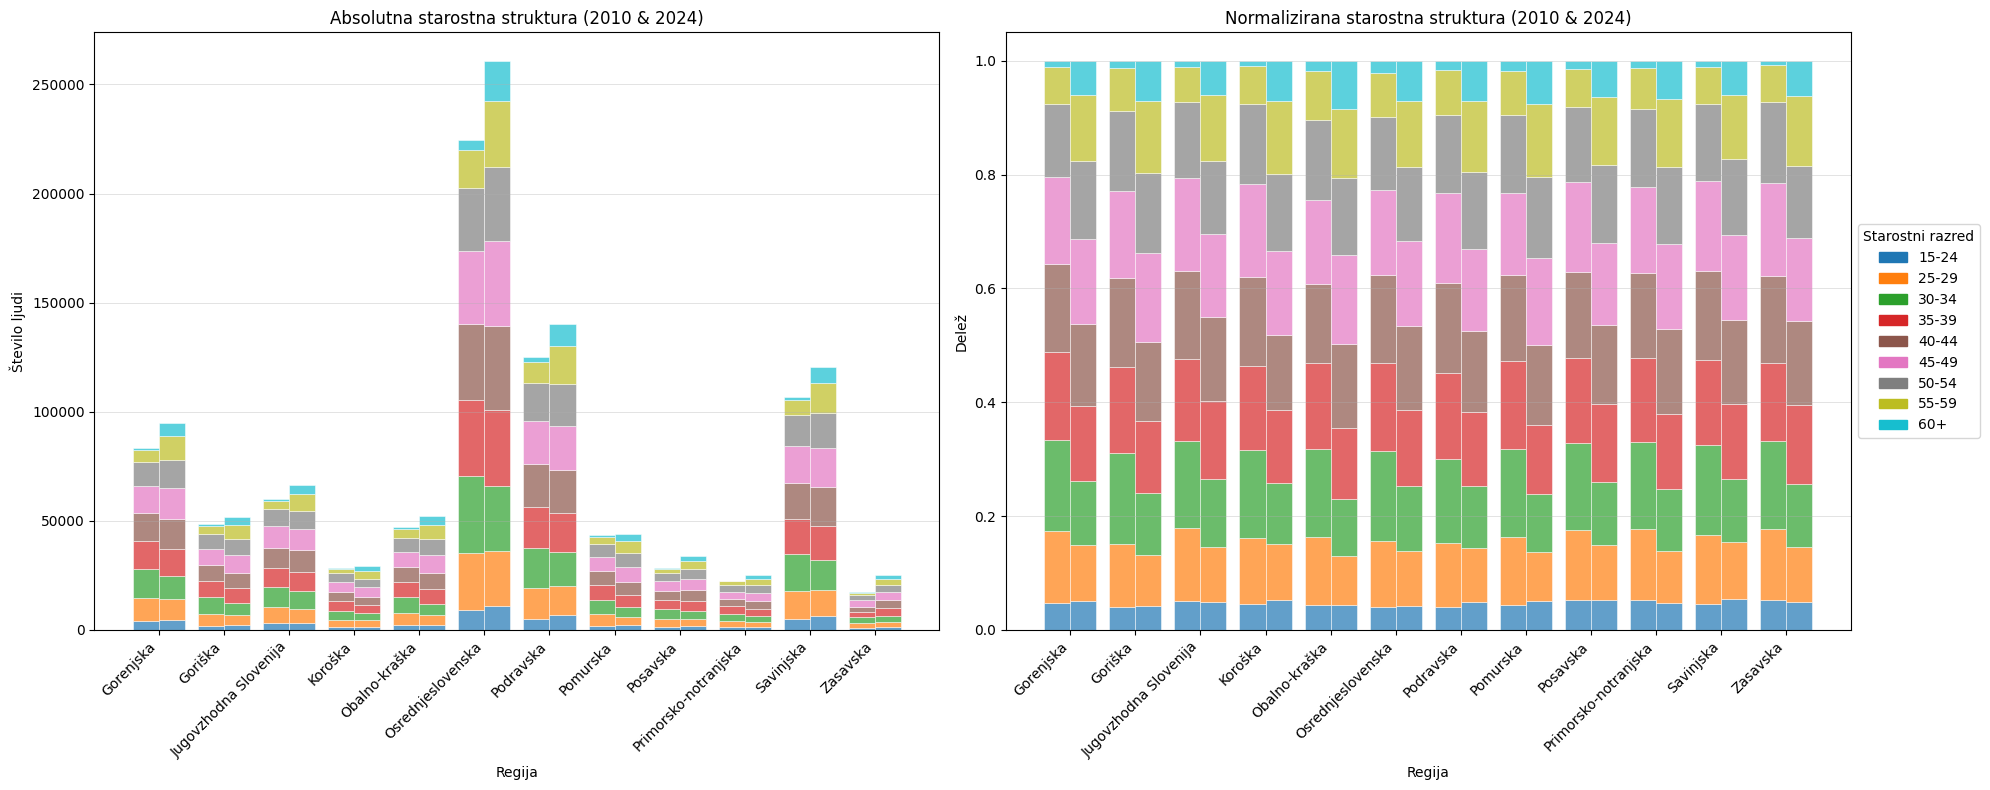

In [9]:
data_2010 = data_delo[(data_delo['YEAR'] == 2010) & (data_delo['STATISTIČNA REGIJA'] != 'SLOVENIJA')]
data_2024 = data_delo[(data_delo['YEAR'] == 2024) & (data_delo['STATISTIČNA REGIJA'] != 'SLOVENIJA')]

data_2010_grouped = data_2010.groupby(['STATISTIČNA REGIJA', 'STAROSTNI RAZRED'])['DATA'].mean().unstack(fill_value=0)
data_2024_grouped = data_2024.groupby(['STATISTIČNA REGIJA', 'STAROSTNI RAZRED'])['DATA'].mean().unstack(fill_value=0)

data_2010_normalized = data_2010_grouped.div(data_2010_grouped.sum(axis=1), axis=0)
data_2024_normalized = data_2024_grouped.div(data_2024_grouped.sum(axis=1), axis=0)

age_groups = data_2010_grouped.columns
colors = plt.get_cmap("tab10", len(age_groups))
bar_width = 0.4
x = np.arange(len(data_2010_grouped))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

bottom_2010 = np.zeros(len(data_2010_grouped))
bottom_2024 = np.zeros(len(data_2024_grouped))

for i, age_group in enumerate(age_groups):
    ax1.bar(x - bar_width/2, data_2010_grouped[age_group], width=bar_width,
            bottom=bottom_2010, color=colors(i), alpha=0.7, edgecolor='white', linewidth=0.5)
    ax1.bar(x + bar_width/2, data_2024_grouped[age_group], width=bar_width,
            bottom=bottom_2024, color=colors(i), alpha=0.7, edgecolor='white', linewidth=0.5)
    bottom_2010 += data_2010_grouped[age_group]
    bottom_2024 += data_2024_grouped[age_group]

ax1.set_title('Absolutna starostna struktura (2010 & 2024)')
ax1.set_xlabel('Regija')
ax1.set_ylabel('Število ljudi')
ax1.set_xticks(x)
ax1.set_xticklabels(data_2010_grouped.index, rotation=45, ha='right')
ax1.grid(axis='y', linewidth=0.5, alpha=0.5)

bottom_2010_norm = np.zeros(len(data_2010_normalized))
bottom_2024_norm = np.zeros(len(data_2024_normalized))

for i, age_group in enumerate(age_groups):
    ax2.bar(x - bar_width/2, data_2010_normalized[age_group], width=bar_width,
            bottom=bottom_2010_norm, color=colors(i), alpha=0.7, edgecolor='white', linewidth=0.5)
    ax2.bar(x + bar_width/2, data_2024_normalized[age_group], width=bar_width,
            bottom=bottom_2024_norm, color=colors(i), alpha=0.7, edgecolor='white', linewidth=0.5)
    bottom_2010_norm += data_2010_normalized[age_group]
    bottom_2024_norm += data_2024_normalized[age_group]

ax2.set_title('Normalizirana starostna struktura (2010 & 2024)')
ax2.set_xlabel('Regija')
ax2.set_ylabel('Delež')
ax2.set_xticks(x)
ax2.set_xticklabels(data_2010_normalized.index, rotation=45, ha='right')
ax2.grid(axis='y', linewidth=0.5, alpha=0.5)

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors(i)) for i in range(len(age_groups))]
ax2.legend(legend_handles, age_groups, title='Starostni razred',
           loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

Opazimo, da so starejše starostne skupine zelo povečale in da je trend isti v vseh regijah.

## Povprečna startost regije


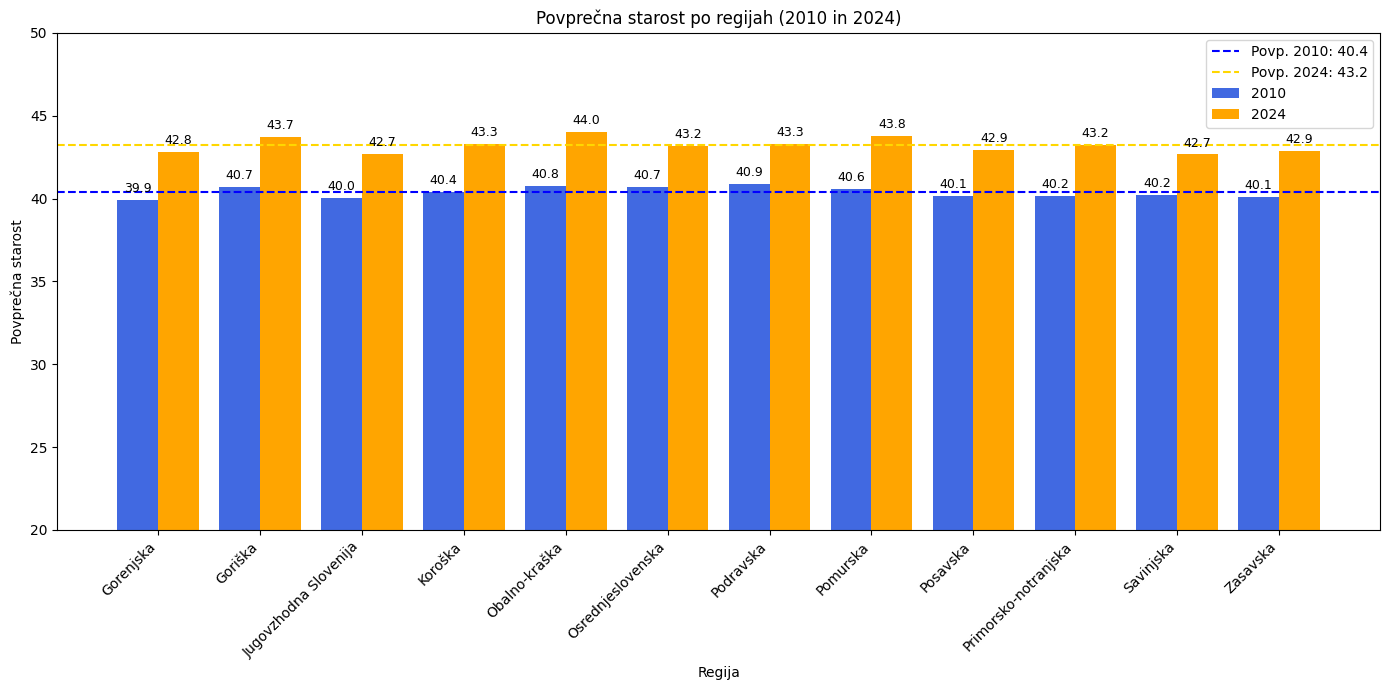

In [10]:
def povprecna_starost(starostni_razred):
    if '+' in starostni_razred:
        return 65
    spodnja, zgornja = map(int, starostni_razred.split('-'))
    return (spodnja + zgornja) / 2

def pripravi_podatke_po_regijah(leto):
    # Če YEAR ni string, potem ne pretvarjaj, sicer pretvori v string
    if data_delo['YEAR'].dtype == object:
        filter_leto = data_delo['YEAR'] == str(leto)
    else:
        filter_leto = data_delo['YEAR'] == leto

    df = data_delo[filter_leto & (data_delo['STATISTIČNA REGIJA'] != 'SLOVENIJA')].copy()
    df['povp_starost'] = df['STAROSTNI RAZRED'].apply(povprecna_starost)

    grouped = df.groupby('STATISTIČNA REGIJA')
    # Izračun tehtanega povprečja po regijah
    povp = grouped.apply(lambda x: np.average(x['povp_starost'], weights=x['DATA']), include_groups=False)
    return povp

povp_2010 = pripravi_podatke_po_regijah(2010)
povp_2024 = pripravi_podatke_po_regijah(2024)

combined = pd.concat([povp_2010, povp_2024], axis=1)
combined.columns = ['2010', '2024']
combined = combined.sort_index()

fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.4
x = np.arange(len(combined.index))

bars1 = ax.bar(x - bar_width/2, combined['2010'], width=bar_width, label='2010', color='royalblue')
bars2 = ax.bar(x + bar_width/2, combined['2024'], width=bar_width, label='2024', color='orange')

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', 
            ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', 
            ha='center', va='bottom', fontsize=9)

mean_2010 = combined['2010'].mean()
mean_2024 = combined['2024'].mean()
ax.axhline(mean_2010, color='blue', linestyle='--', linewidth=1.5, label=f'Povp. 2010: {mean_2010:.1f}')
ax.axhline(mean_2024, color='gold', linestyle='--', linewidth=1.5, label=f'Povp. 2024: {mean_2024:.1f}')

ax.set_ylim([20, 50])
ax.set_xticks(x)
ax.set_xticklabels(combined.index, rotation=45, ha='right')
ax.set_ylabel('Povprečna starost')
ax.set_xlabel('Regija')
ax.set_title('Povprečna starost po regijah (2010 in 2024)')
ax.legend()
plt.tight_layout()
plt.show()

Opazimo, da se je povprečna starost aktivnega prebivalstva zvišala za 2,8 leta. Najstarejša je obalna regija, kar lahko povezujemo tudi s priseljevanjem starejših prebivalcev, ki so blizu upokojitve. 
(POZOR: Tukaj sem spremenila y skalo, da se bolje opazijo razlike v povprečni starosti.)

## Povezava med delovnim prebivalstvom in BDP

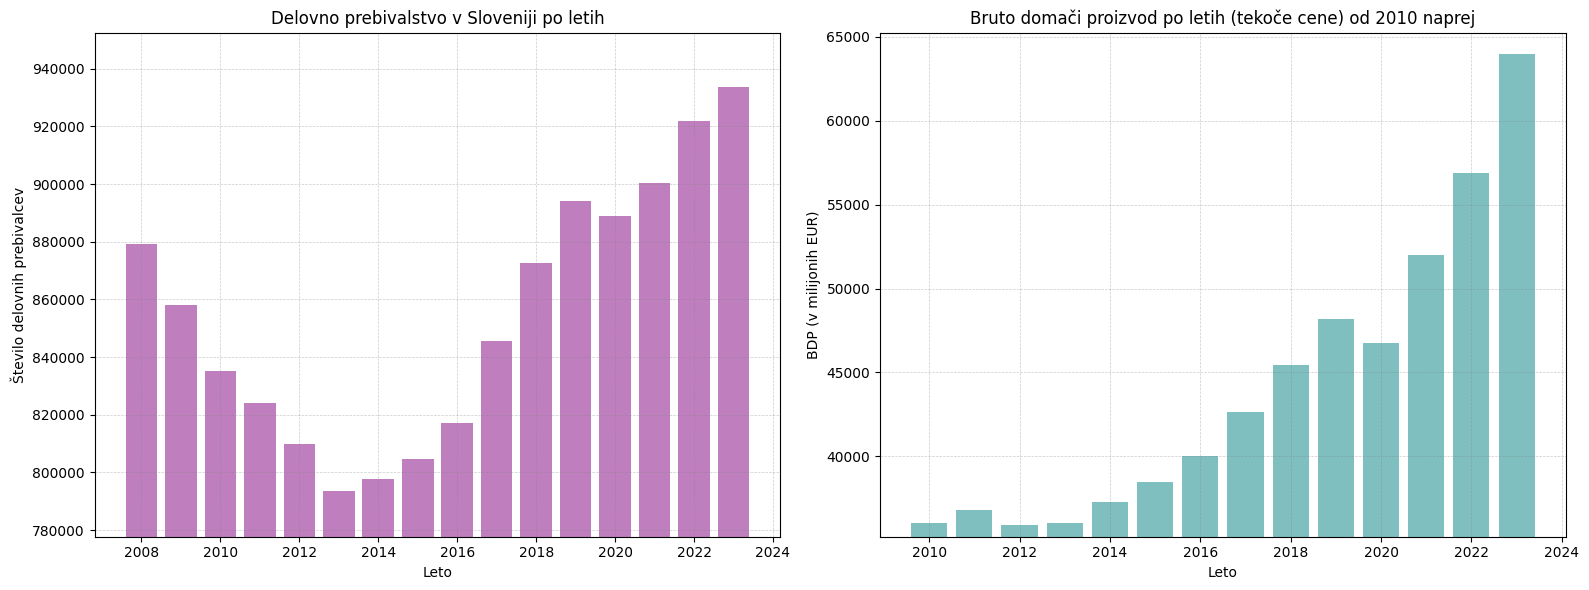

In [11]:
# Podatki o delovnem prebivalstvu
yearly_data = data_preb[
    (data_preb['MERITVE'] == 'Število delovno aktivnih prebivalcev (po prebivališču)') &
    (data_preb['STATISTIČNA REGIJA'] == 'SLOVENIJA')
].copy()

yearly_data['LETO'] = yearly_data['LETO'].astype(int)
yearly_data = yearly_data.sort_values('LETO')

# Podatki o BDP
bdp = data_bdp[
    (data_bdp['TRANSAKCIJE'] == 'Bruto domači proizvod') &
    (data_bdp['MERITVE'] == 'Tekoče cene (mio EUR)')
].copy()

bdp['LETO'] = bdp['LETO'].astype(int)
bdp = bdp[bdp['LETO'] >= 2010].sort_values('LETO')

# Prikaz grafov
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prvi graf - Delovno prebivalstvo
axes[0].bar(yearly_data['LETO'], yearly_data['DATA'], color='purple', alpha=0.5)
axes[0].set_xlabel('Leto')
axes[0].set_ylabel('Število delovnih prebivalcev')
axes[0].set_title('Delovno prebivalstvo v Sloveniji po letih')
axes[0].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
axes[0].set_ylim([yearly_data['DATA'].min() * 0.98, yearly_data['DATA'].max() * 1.02])

# Drugi graf - BDP
axes[1].bar(bdp['LETO'], bdp['DATA'], color='teal', alpha=0.5)
axes[1].set_xlabel('Leto')
axes[1].set_ylabel('BDP (v milijonih EUR)')
axes[1].set_title('Bruto domači proizvod po letih (tekoče cene) od 2010 naprej')
axes[1].grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.4)
axes[1].set_ylim([bdp['DATA'].min() * 0.98, bdp['DATA'].max() * 1.02])

plt.tight_layout()
plt.show()

(POZOR: Tukaj sem spremenila y skalo, da se bolje opazijo razlike v številu delovno aktivnega prebivalstva in BDP-ja skozi leta.)

In [12]:
# Primer podatkov
data_labor = pd.DataFrame({
    'LETO': list(range(2010, 2024)),
    'DATA': [850000, 860000, 855000, 858000, 860500, 863000, 870000, 872000, 875000, 877000, 880000, 885000, 888000, 890000]
})

data_bdp = pd.DataFrame({
    'LETO': list(range(2010, 2024)),
    'DATA': [35000, 36000, 37000, 37500, 38000, 39000, 40000, 40500, 41000, 41200, 41500, 41800, 42000, 42200]
})

merged = pd.merge(data_labor, data_bdp, on='LETO', suffixes=('_labor', '_bdp'))
correlation = merged['DATA_labor'].corr(merged['DATA_bdp'])
print(f"Korelacija med delovno aktivnim prebivalstvom in BDP: {correlation:.3f}")

Korelacija med delovno aktivnim prebivalstvom in BDP: 0.951


Korelacija med delovno aktivnim prebivalstvom in bruto domačim proizvodom (BDP), ki znaša 0.951, kaže na zelo močno pozitivno povezanost med tema dvema spremenljivkama. To pomeni, da se BDP praviloma povečuje, kadar se povečuje tudi število delovno aktivnih prebivalcev – in obratno. To potrjuje, da je BDP eden izmed ključnih dejavnikov gospodarske rasti.

## Končna potrošnja države v podatkov o BDP


In [13]:
data_bdp = pd.read_csv('../podatki/bdp.csv', sep=';', encoding='utf-8')
# 1. Izlušči 'Končna potrošnja države' iz data_bpd
gov = data_bdp[
    (data_bdp['TRANSAKCIJE'] == '....Končna potrošnja države') &
    (data_bdp['MERITVE'] == 'Tekoče cene (mio EUR)')
    ].copy()

# Preimenuj in pretvori tip
gov['LETO'] = gov['LETO'].astype(int)
gov['GOV_CONS'] = gov['DATA']


data_labor = data_delo.groupby('YEAR')['DATA'].mean().reset_index().astype({'YEAR': 'int'})
data_labor.columns = ['LETO', 'LABOR']

bdp_series = data_bdp[
    (data_bdp['TRANSAKCIJE'] == 'Bruto domači proizvod') &
    (data_bdp['MERITVE'] == 'Tekoče cene (mio EUR)')
    ][['LETO', 'DATA']].copy()
bdp_series['LETO'] = bdp_series['LETO'].astype(int)
bdp_series = bdp_series.rename(columns={'DATA': 'BDP'})

Najprej smo filtrirale vrstico, ki predstavlja končno potrošnjo države v tekočih cenah (v milijonih) in pretvorile leto iz niza v celo število, za lažjo obdelavo. Poimenovana je GOV_CONS (consumption). Pod LABOR spada delovno aktivno prebivalstvo - skupno število zaposlenih vsako leto (dobljeno z group-by: združevanje in seštevek vseh starostnih skupin in regij v SLoveniji).

Z BDP je poimenovana vrstica - Bruto Domači Proizvod - pri tekočih cenah. To nam omogoči spremljanje temeljnih makroekonomskih kazalnikov, kot so oskrba trga dela in ekonomska proizvodnja.

In [14]:
df_all = (
    data_labor
    .merge(bdp_series, on='LETO', how='inner')
    .merge(gov[['LETO', 'GOV_CONS']], on='LETO', how='inner')
    .sort_values('LETO')
    .reset_index(drop=True)
)

df_all

,LETO,LABOR,BDP,GOV_CONS
0,2010,14274.170940,36050.778497,7426.790663
1,2011,14084.900285,36782.213207,7626.041688
2,2012,13846.175214,35933.578282,7364.10086
3,2013,13565.753561,36041.266795,7148.87983
4,2014,13637.472934,37270.934917,7100.020959
5,2015,13754.477208,38493.890577,7295.451541
6,2016,13969.386040,40013.155346,7691.146768
7,2017,14452.205128,42625.477901,7934.050863
8,2018,14919.176638,45462.435468,8369.087343
9,2019,15285.970085,48156.453885,8899.168175


**Združevanje serij**:
Za vsako leto dobimo tri pomembne stolpce: LABOR (število delovno aktivnih), BDP (v milijonih evrov) in GOV_CONS (končna potrošnja države, prav tako v milijonih evrov)

In [15]:
# 2-letni proračunski zamik
df_all['GOV_CONS_LAG2'] = df_all['GOV_CONS'].shift(2)

# korelacijski izračun
corr_current = df_all[['LABOR', 'GOV_CONS']].corr().loc['LABOR', 'GOV_CONS']
corr_lag2 = df_all[['LABOR', 'GOV_CONS_LAG2']].corr().loc['LABOR', 'GOV_CONS_LAG2']
print(f"Korelacija brez zamika: {corr_current:.3f}")
print(f"Korelacija z 2-letnim zamikom: {corr_lag2:.3f}")

Korelacija brez zamika: 0.933
Korelacija z 2-letnim zamikom: 0.871


Ker se proračun načrtuje in sprejema približno dve leti vnaprej, smo naše podatke zamaknile za dve leti.


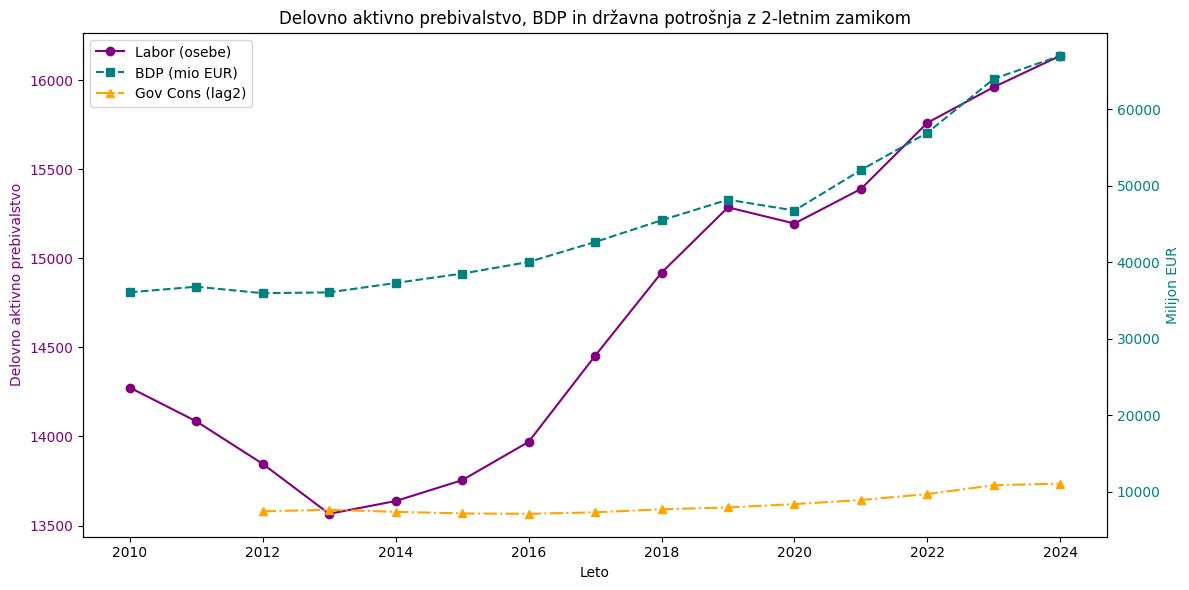

In [16]:
df_all['LETO'] = pd.to_numeric(df_all['LETO'], errors='coerce')
df_all['LABOR'] = pd.to_numeric(df_all['LABOR'], errors='coerce')
df_all['BDP'] = pd.to_numeric(df_all['BDP'], errors='coerce')
df_all['GOV_CONS_LAG2'] = pd.to_numeric(df_all['GOV_CONS_LAG2'], errors='coerce')

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_all['LETO'], df_all['LABOR'], 'o-', label='Labor (osebe)', color='purple')
ax1.set_xlabel('Leto')
ax1.set_ylabel('Delovno aktivno prebivalstvo', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')

ax2 = ax1.twinx()
ax2.plot(df_all['LETO'], df_all['BDP'], 's--', label='BDP (mio EUR)', color='teal')
ax2.plot(df_all['LETO'], df_all['GOV_CONS_LAG2'], '^-.', label='Gov Cons (lag2)', color='orange')
ax2.set_ylabel('Milijon EUR', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Delovno aktivno prebivalstvo, BDP in državna potrošnja z 2-letnim zamikom')
plt.tight_layout()
plt.show()

Končna potrošnja države je osrednji del javnofinančnih izdatkov (socialna varnost, javno zdravstrvo, izobraževanje itd.), spreminjanje le-teh pa kaže na to, kako politika usmerja del DDP-ja nazaj v družbo.

Na grafu so lepo opazne gospodarske krize in epidemija COVID pri številu delovno aktivnega prebivalstva. To je močno padlo med 2010 in 2013, in nato še enkrat (manj) okoli leta 2020 - COVID-19. Kljub manjšemu padcu v letu 2020 lahko opazimo konstantno rast od leta 2014 dalje.

Pri BDP (turkizna barva) lahko vidimo zelo majhen padec med letoma 2010 in 2013, kar prav tako odraža učinke krize. Od tega leta dalje se začne rast (s ponovnim padcem zaradi epidemije).

Graf nakazuje, da smo kljub učinkom kriz in epidemij lepo okrevali in se po vsakem padcu vrnili na rast. Ob pogledu na celotno obdobje (2010 - 2023) se lahko strinjamo, da ga zaznamuje rast vseh treh serij, kar podpira dejstvo, da je kombinacija gospodarske rasti in javnih izdatkov pomagača rasti trga dela.

Iz podatkov lahko zaključimo, da moramo, če želimo spdobujati trg dela, javnofinančne ukrepe načrtovati vnaprej in pričakovati zamik njihovega polnega učinka.



# Napoved
z pomočjo linerne regresije, bomo puskusili napovedati rast BDP-ja in število aktivnega delavnega prebivalstva

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression

aktivni = yearly_data[['LETO', 'DATA']].rename(columns={'DATA': 'aktivni'})
bdp_cisti = bdp[['LETO', 'DATA']].rename(columns={'DATA': 'bdp'})

skupni_podatki = pd.merge(aktivni, bdp_cisti, on='LETO')

X = skupni_podatki[['LETO']]
y_aktivni = skupni_podatki['aktivni']
y_bdp = skupni_podatki['bdp']

model_aktivni = LinearRegression()
model_aktivni.fit(X, y_aktivni)

model_bdp = LinearRegression()
model_bdp.fit(X, y_bdp)

# Napoved za leta 2025 do 2029
leta_napovedi = pd.DataFrame({'LETO': range(2025, 2030)})

napoved_aktivni = model_aktivni.predict(leta_napovedi)
napoved_bdp = model_bdp.predict(leta_napovedi)

# Združi prejšnje in napovedane podatke
napovedani_podatki = leta_napovedi.copy()
napovedani_podatki['aktivni'] = napoved_aktivni
napovedani_podatki['bdp'] = napoved_bdp

skupni_vsi = pd.concat([skupni_podatki, napovedani_podatki], ignore_index=True)

skupni_vsi

,LETO,aktivni,bdp
0,2010,835039.000000,36050.778497
1,2011,823967.000000,36782.213207
2,2012,810001.000000,35933.578282
3,2013,793597.000000,36041.266795
4,2014,797792.000000,37270.934917
5,2015,804637.000000,38493.890577
6,2016,817209.000000,40013.155346
7,2017,845454.000000,42625.477901
8,2018,872772.000000,45462.435468
9,2019,894229.000000,48156.453885


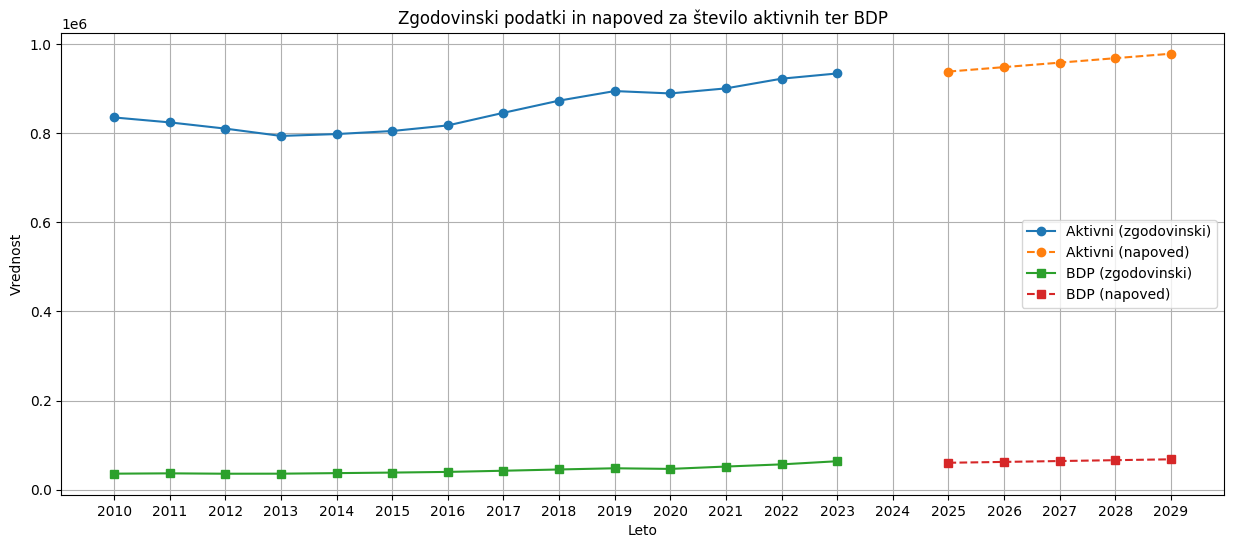

In [18]:
plt.figure(figsize=(15,6))

plt.plot(skupni_podatki['LETO'], skupni_podatki['aktivni'], label='Aktivni (zgodovinski)', marker='o')
plt.plot(napovedani_podatki['LETO'], napovedani_podatki['aktivni'], label='Aktivni (napoved)', marker='o', linestyle='--')

plt.plot(skupni_podatki['LETO'], skupni_podatki['bdp'], label='BDP (zgodovinski)', marker='s')
plt.plot(napovedani_podatki['LETO'], napovedani_podatki['bdp'], label='BDP (napoved)', marker='s', linestyle='--')

plt.xlabel('Leto')
plt.ylabel('Vrednost')
plt.title('Zgodovinski podatki in napoved za število aktivnih ter BDP')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))  # oznake vsako leto
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))  # cela leta brez decimalk

plt.show()

Z uporabo linearne regresije smo napovedali število delovno aktivnih ljudi in bruto domači proizvod (BDP) za obdobje med letoma 2025 in 2029.

Napovedi kažejo, da se bo število delovno aktivnih nekoliko povečalo – s približno 938.000 v letu 2025 na skoraj 978.000 v letu 2029. 
Hkrati naj bi BDP rasel s približno 60,5 milijarde evrov v letu 2025 na okoli 68,3 milijarde evrov leta 2029. To pomeni, da pričakujemo gospodarsko rast in večjo produktivnost v naslednjih petih letih.

Pomembno pa je poudariti, da gre za preprosto napoved, ki temelji na dosedanjih trendih, zato ne upošteva morebitnih nepričakovanih dogodkov ali večjih sprememb v gospodarstvu.